In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time
from abc import ABC, abstractmethod

In [2]:
def standardNormalGaussianDensity(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-.5*np.power(x,2))

def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1



In [3]:
class BinomialTree:
    def __init__(self, S0, T, r, q, sigma, noSteps):
        self.r = r
        self.q = q
        self.T = T
        self.noSteps = noSteps
        self.dt = T/(noSteps - 1)
        self.drift = (r-q-sigma**2/2)*self.dt
        self.randomInc = sigma*np.sqrt(self.dt)
        self.layers = [np.zeros(i+1) for i in range(noSteps)]
        self.layers[0][0] = S0

        self.split()

    name = 'Binomial Tree'

    def split(self):

        for i in range(1, self.noSteps):

            for j in range(i+1):

                self.layers[i][j] = self.layers[i-1][0]*np.exp(-self.randomInc + 2*j*self.randomInc)

            self.layers[i][:]*= np.exp(self.drift)

    def evaluateOption(self, optionPayoff, filterFn = None ):

        prevLayer = optionPayoff(self.layers[-1])
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):

                if filterFn is not None:
                    prevLayer*= filterFn(self.layers[prevLayer.size-1])

                currLayer[j] = np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]


In [4]:
class StockMovementGenerator(ABC):
    """Abstract base class for generating stock price movements"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int, T:float):
        self.initial_price = initial_price
        self.n = n_steps # Dimensionality of Monte Carlo / Number of Increments
        self.d = n_paths # Number of Iterations / Paths
        self.T = T  # Timespan
        self.dt = self.T/(self.n-1)

    @abstractmethod
    def generate(self):
        """Generate price movements"""
        pass

class GeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 riskFreeInterestArray: np.array, q:float, sigmaArray: np.array , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.riskFreeInterestArray = riskFreeInterestArray  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigmaArray = sigmaArray  # historic volatility
        self.times = np.linspace(0., self.T, self.n)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)
        self.n_steps = n_steps
        self.n_paths = n_paths

    def generate(self):
        """
        Generate prices using GBM
        The generator function can take in a changing volatility

        """
        # Computing root-mean-square r
        rmsR = np.ones(shape=self.riskFreeInterestArray.shape)
        rmsR[0] = self.riskFreeInterestArray[0]
        rmsR[1:] = np.sqrt((self.riskFreeInterestArray[:-1]**2 + self.riskFreeInterestArray[1:]**2)/2)
        rmsR = np.repeat(rmsR.reshape(self.n_steps,1), self.n_paths, axis = 1)


         # Computing root-mean-square sigma
        rmsSigma = np.ones(shape=self.sigmaArray.shape)
        rmsSigma[0] = self.sigmaArray[0]
        rmsSigma[1:] = np.sqrt((self.sigmaArray[:-1]**2 + self.sigmaArray[1:]**2)/2)
        rmsSigma = np.repeat(rmsSigma.reshape(self.n_steps,1), self.n_paths, axis = 1)

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n, self.d))
        dB[1:, :] = np.sqrt(self.dt) * np.random.normal(size=(self.n-1, self.d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = self.S0*np.exp((rmsR-self.q-rmsSigma**2/2)*self.timesArray + rmsSigma*B)
        return S



In [5]:
def asianOptionPayoff(array, K):
    return np.maximum(np.mean(array,axis = 0) - K, 0)

def EuropeanCallOptionPayoff(array, K):
    return np.maximum(array - K,0)

def EuropeanPutOptionPayoff(array, K):
    return np.maximum(K - array,0)


In [6]:
def checkConvergence(derivativePayoff, T, minPower, maxPower, n_paths, filterFunction = None):
    """Check for convergence of derivative price

    derivativePayoff : function that returns the derivative payoff
    T : time to maturity
    """

    _derivativeVec = np.zeros((maxPower - minPower,n_paths))
    _priceMean = np.zeros(maxPower - minPower)
    _priceStd = np.zeros(maxPower - minPower)


    for idx,k in enumerate(range(minPower,maxPower)):
        frequency = 2**k
        n_steps = frequency*T

        riskFreeInterestArray = np.ones(n_steps)*r
        sigmaArray = np.ones(n_steps)*sigma
        rRMS = np.sqrt(np.mean(riskFreeInterestArray**2))

        GBM = GeometricBrownianMotion(S0, n_steps, n_paths, riskFreeInterestArray, q, sigmaArray, T)
        S = GBM.generate()

        if filterFunction is not None:
            S = filterFunction(S)

        _derivativeVec[idx,:] = derivativePayoff(S)*np.exp(-rRMS*T)
        _priceMean[idx] = np.mean(_derivativeVec[idx,:])
        _priceStd[idx] = np.std(_derivativeVec[idx,:])/np.sqrt(n_paths)

    return  _priceMean, _priceStd


# Pricing Asian options

The payoff function for Asian options is $ \large( \frac{1}{n} \sum_{j=1}^{N} S_{t_j} - K \large)_{+} $ for time $t_n$

In other words, the payoff is a function of the average stock price until maturity

In [7]:
t = 0
K = 103
S0 = 100
q = 0.03
sigma = .1
r = .05
minPower = 2
maxPower = 8
T = 1
_pathsArray = np.power(2,range(minPower,maxPower))

In [13]:
n_paths = int(1e6) # From previous projects, this gives a low statistical error
# Asian Option Study Convergence of setting dates
n_steps = np.power(2,np.arange(minPower, maxPower))

_derivativeVec = np.zeros((maxPower - minPower,n_paths))
_priceMean = np.zeros(maxPower - minPower)
_priceStd = np.zeros(maxPower - minPower)

for idx,k in enumerate(range(minPower,maxPower)):

    n_steps = (2**k)*T
    GBM = GeometricBrownianMotion(S0, n_steps, n_paths, r*np.ones(n_steps), q, sigma*np.ones(n_steps), T)
    _derivativeVec[idx,:] = asianOptionPayoff(GBM.generate(),K)*np.exp(-r*T)
    _priceMean[idx] = np.mean(_derivativeVec[idx,:])
    _priceStd[idx] = np.std(_derivativeVec[idx,:])/np.sqrt(n_paths)


Using parameters: r = 0.05, q = 0.03, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 103.00


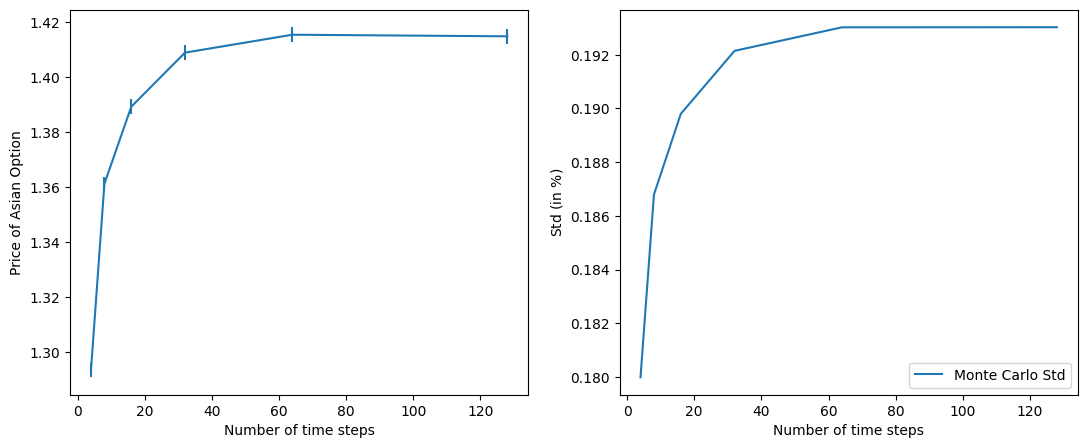

In [18]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(_pathsArray, _priceMean, yerr = _priceStd, label = f'GBM Asian Option')
ax[1].plot(_pathsArray, _priceStd*100/_priceMean[-1], label = "Monte Carlo Std")

ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Price of Asian Option')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Std (in $\%$)')
ax[1].legend()


In [15]:
# The time discretization bias
discrBias = abs(np.diff(_priceMean))
# Statistical bias
MCbias = _priceStd[1:]

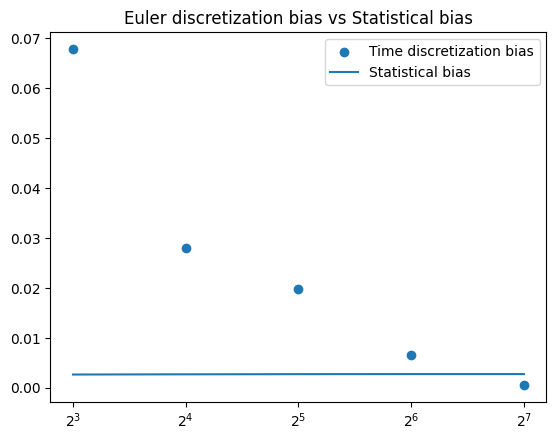

In [16]:
fig,ax = plt.subplots(1,1)
ax.set_xscale('log', base = 2)
ax.set_title('Euler discretization bias vs Statistical bias')
ax.scatter(_pathsArray[1:], discrBias, label = 'Time discretization bias')
ax.plot(_pathsArray[1:], MCbias, label = 'Statistical bias')
ax.legend()

Statistical error is roughly equal to time discretization bias at roughly 128 steps and $10^6$ paths

This mean that in order to get a reasonable approximation for the Asian option we need no less than roughly 100 time steps for $10^6$ paths

The Monte Carlo bias of the Asian options and path dependent derivatives in general is dependent on $\delta t$ the time step. The shorter the time step the smaller the bias. Adding paths does not change the time bias

# Pricing Discrete Barrier Options

In [8]:
t = 0
K = 103
S0 = 100
q = 0.03
sigma = .1
T=1
r = .05

i) Down and out call with barrier $H=95$

Down and out barrier options expire worthless if the stock price ever reaches $H$, otherwise they are worth the same as a vanilla European call option

The $H=95$ barrier region is explored, as in this case the barrier is close to the strike. This means the Barrier Option will have a significantly different value to the Vanilla Option as a lot of paths will nullify upon crossing the barrier

Exploring a region where the barrier is far away from the stike means there will be few paths that become null and the value of the Barrier Option will be almost identical to the Vanilla Option

In [9]:
B = 95

Get an estimate on the Down and Out Call Option value using the Binomial Tree Algorithm

In [10]:
sT = BinomialTree(S0, T, r, q, sigma, noSteps = np.power(2,10))

In [11]:
binaryTreeDownOutCall = sT.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)

In [11]:
def DownAndOutCallFilter(S, B, K):
    """
    S : stock price array
    B : barrier price
    K : strike price
    """
    nullPathsIdx = np.where(np.min(S, axis = 0) - B < 0)
    S[-1, nullPathsIdx] = K # This essentially renders that specific path valueless

    return S[-1,:]


Using parameters: r = 0.05, q = 0.03, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 103.00, B : 95.00


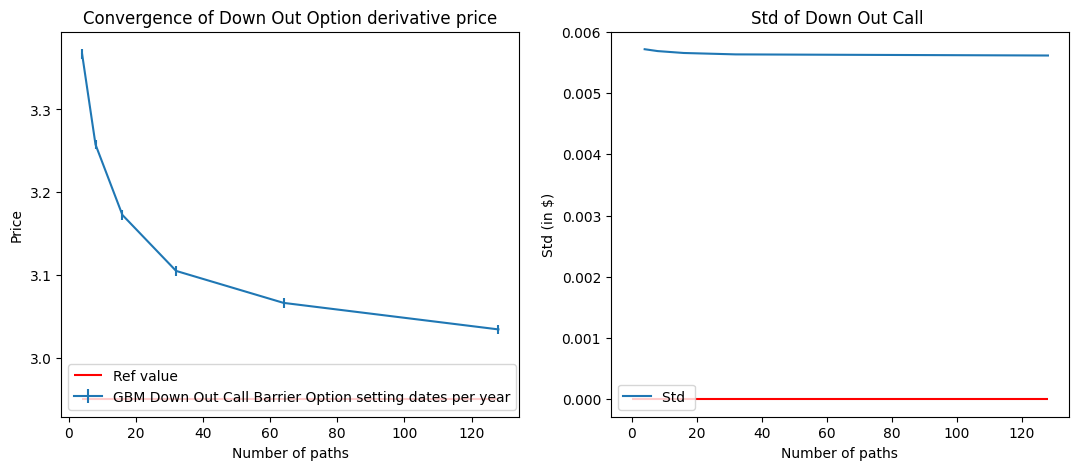

In [32]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
Npaths = int(1e6)
minPower = 2
maxPower = 8
_pathsArray = np.power(2,np.arange(minPower,maxPower))
downOutpriceMean, downOutpriceStd = checkConvergence(
    lambda x: EuropeanCallOptionPayoff(x, K) ,
    T=T,
    minPower = minPower,
    maxPower = maxPower,
    n_paths = Npaths,
    filterFunction = lambda x: DownAndOutCallFilter(x, B, K)
    )
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(_pathsArray, downOutpriceMean, yerr = downOutpriceStd, label = f'GBM Down Out Call Barrier Option setting dates per year')
ax[0].set_title('Convergence of Down Out Option derivative price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = _pathsArray[0], xmax = _pathsArray[-1], y =binaryTreeDownOutCall, color = 'red', label='Ref value')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[1].plot(_pathsArray, downOutpriceStd, label = f"Std ")
ax[1].set_title('Std of Down Out Call ')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()
_downAndOutCallBarrier = downOutpriceMean[-1]

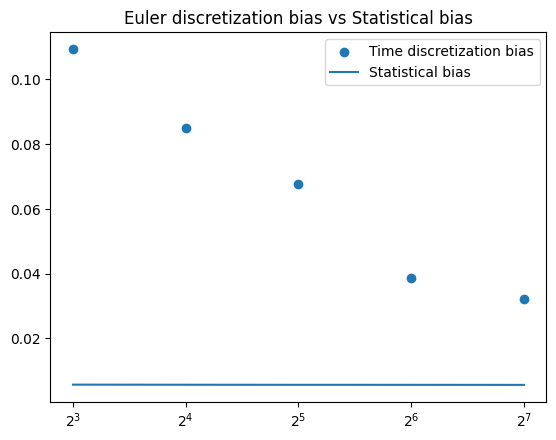

In [33]:
# The time discretization bias
discrBias = abs(np.diff(downOutpriceMean))
# Statistical bias
MCbias = downOutpriceStd[1:]
fig,ax = plt.subplots(1,1)
ax.set_xscale('log', base = 2)
ax.set_title('Euler discretization bias vs Statistical bias')
ax.scatter(_pathsArray[1:], discrBias, label = 'Time discretization bias')
ax.plot(_pathsArray[1:], MCbias, label = 'Statistical bias')
ax.legend()

The bias of the Monte Carlo is $O(\sqrt{\delta t})$, and thus a convergence is guaranteed only upon increasing the frequency of checks whether the barrier has been passed

By the convergence trend, it looks as tough we need about $2^9$ steps for $10^6$ paths to get a good accuracy

In [12]:
downOutpriceMean, downOutpriceStd = checkConvergence(
    lambda x: EuropeanCallOptionPayoff(x, K) ,
    T=T,
    minPower = 10,
    maxPower = 11,
    n_paths = int(1e5),
    filterFunction = lambda x: DownAndOutCallFilter(x, B, K)
    )

In [15]:
downOutCallDisparity = (downOutpriceMean[-1] - binaryTreeDownOutCall)*100/binaryTreeDownOutCall
print(f'Disparity between Monte Carlo Down Out call for {10**5} paths and {2**10} time steps is {downOutCallDisparity:.2f} %')

Disparity between Monte Carlo Down Out call for 100000 paths and 1024 time steps is 0.32 %


ii) Down and in call with barrier $H=90$

Down and in barrier options expire worthless if the stock price never reaches $H$, otherwise they are worth the same as a vanilla European call option

In [12]:
def DownAndInCallFilter(S, B, K):
    """
    S : stock price array
    B : barrier price
    K : strike price
    """
    validPathIndices = np.min(S, axis = 0) - B < 0
    nullPaths = np.where(validPathIndices == False)
    S[-1, nullPaths] = K #Renders these specific paths valueless

    return S[-1,:]

In [13]:
binaryTreeDownInCall = BSMcall(S0,K,T,t, r,q,sigma) - binaryTreeDownOutCall

Using parameters: r = 0.05, q = 0.03, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 103.00, B : 95.00


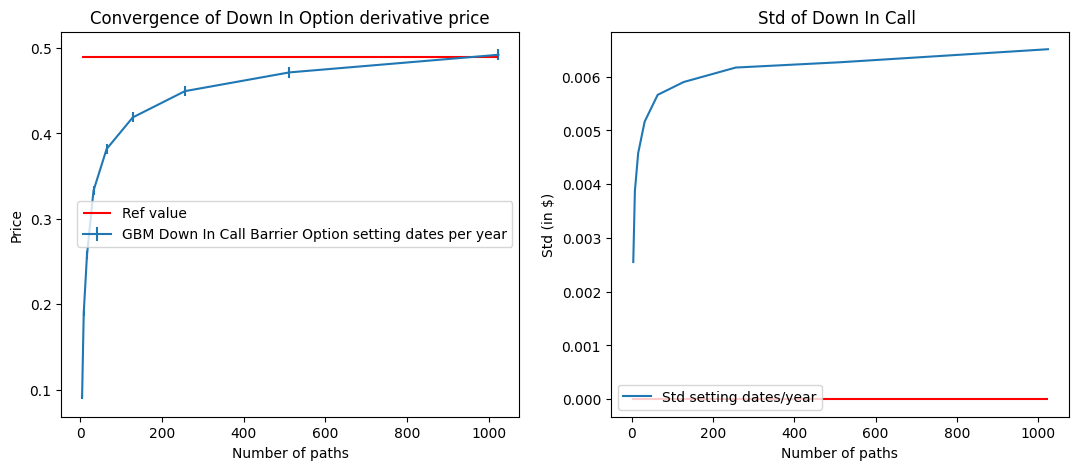

In [15]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
_pathsArray = np.power(2,np.arange(minPower,maxPower))
Npaths = int(1e5)
minPower = 2
maxPower = 11
downInpriceMean, downInpriceStd = checkConvergence(
    lambda x: EuropeanCallOptionPayoff(x, K) ,
    T=T,
    minPower = minPower,
    maxPower = maxPower,
    n_paths = Npaths,
    filterFunction = lambda x: DownAndInCallFilter(x, B, K))
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(_pathsArray, downInpriceMean, yerr = downInpriceStd, label = f'GBM Down In Call Barrier Option setting dates per year')
ax[0].set_title('Convergence of Down In Option derivative price')
ax[0].set_xlabel('Number of time steps')
ax[0].hlines(xmin = _pathsArray[0], xmax = _pathsArray[-1], y =binaryTreeDownInCall, color = 'red', label='Ref value')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[1].plot(_pathsArray, downInpriceStd, label = f"Std setting dates/year")
ax[1].set_title('Std of Down In Call ')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()
_downAndInCallBarrier = downInpriceMean[-1]

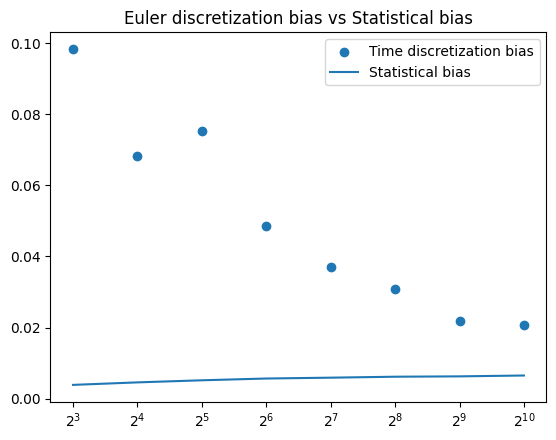

In [16]:
# The time discretization bias
discrBias = abs(np.diff(downInpriceMean))
# Statistical bias
MCbias = downInpriceStd[1:]
fig,ax = plt.subplots(1,1)
ax.set_xscale('log', base = 2)
ax.set_title('Euler discretization bias vs Statistical bias')
ax.scatter(_pathsArray[1:], discrBias, label = 'Time discretization bias')
ax.plot(_pathsArray[1:], MCbias, label = 'Statistical bias')
ax.legend()